# Decomposition Example

First step, set the paths to where to find the motif dictionary and associated code. Note that these are available at http://github.com/sdrogers/motifdb

In [61]:
motifdbcodepath = '/Users/simon/git/motifdb/code/utilities/'
motifdbpath = '/Users/simon/git/motifdb/motifs/'

Load some motifs from the motif database, I'm just loading the massbank ones

In [12]:
import sys
sys.path.append(motifdbcodepath)
from motifdb_loader import load_db
db_list = ['massbank_binned_005']
spectra,motif_metadata = load_db(db_list,motifdbpath)

Looking in /Users/simon/git/motifdb/motifs/massbank_binned_005/*.m2m
	 Found 61
Found total of 61 motif files


spectra is a dictionary with key the filename of the motif and values another dictionary with feature / probability pairs

In [13]:
import numpy as np

make an index of the unique features -- we can only decompose onto features that are loaded from the database

In [17]:
word_index = {}
word_pos = 0
for motif,word_probs in spectra.items():
    for word,probability in word_probs.items():
        if not word in word_index:
            word_index[word] = word_pos
            word_pos += 1

Put the words and motifs into a matrix ($\beta$)

In [19]:
# Create a beta matrix
motif_index = {}
motif_pos = 0
n_motifs = len(spectra)
n_words = len(word_index)
beta = np.zeros((n_motifs,n_words),np.double)
for motif,word_probs in spectra.items():
    motif_index[motif] = motif_pos
    for word,probability in word_probs.items():
        beta[motif_pos,word_index[word]] = probability
    motif_pos += 1

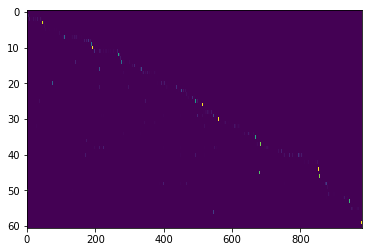

In [27]:
import pylab as plt
%matplotlib inline
plt.imshow(beta,aspect='auto')


Renomalise beta as when we save motifs we threshold on the probabilities and they end up not summing to 1

In [63]:
beta /= beta.sum(axis=1)[:,None]

Load some data..I'm loading massbank data, but other datasets are available. Also assuming the motifs were made using binned features

In [64]:
ldacodepath = '/Users/simon/git/lda/code/'
sys.path.append(ldacodepath)
from ms2lda_feature_extraction import LoadGNPS,MakeBinnedFeatures

import glob
massbank_data = glob.glob('/Users/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/fingerid-104-traindata/spectra_massbank/*.ms')
sub_data = massbank_data[:100]
l = LoadGNPS()
ms1,ms2,spectral_metadata = l.load_spectra(sub_data)
m = MakeBinnedFeatures()
corpus,word_mz_range = m.make_features(ms2)
corpus = corpus[corpus.keys()[0]]

Processed 100 spectra
100 documents
After removing empty words, 3695 words left


Do the decomposition

Some points to note here:
 - Features in the spectra that are not in the motifs don't add anything to they get skipped. I compute (`proportion_in`) the percentage of intensity that is usable.
 - This should be taken into account when interpreting the spectra-motif probabilities (`theta`). These values can be interpreted as the proportion of the usable part of the spectra, and not the total.
 - I also compute overlap score, as it's useful to see how much of the motif is in the spectrum

This is a handy function to compute the overlap score

In [65]:
def compute_overlap(phi_matrix,motif_pos,beta_row,word_index):
    overlap_score = 0.0
    for word in phi_matrix:
        if word in word_index:
            word_pos = word_index[word]
            if phi_matrix[word] == None:
                continue
            else:
                overlap_score += phi_matrix[word][motif_pos]*beta_row[word_pos]
    return overlap_score

 - This is the actual decomposition. 
 - The main loop goes over 100 times, this is probably overkill but it jumps out if the total absolute change in `gamma` is less than `1e-6`.
 - This code doesn't compute alpha, but I can add that if necessary
 - I get a warning about a `log(0)`. This is due to some entries in beta being 0, and it doesn't cause any problem, but could be removed by setting all the zero values to somethign very small and then re-normalising the beta matrix.
 - I do some plotting at the end to show how stuff can be exposed
 - If you wanted to see the decomposition at the individual feature level then you would need to keep hold of `phi_matrix` which gives (for each word), the probabilities over each motif.

In [69]:
from scipy.special import psi as psi
theta = {}
K = n_motifs
alpha = 1 # will have some effect, but there's no way to set it. Making it low means we'll get sparse solutions
overlap_scores = {}
for doc in corpus:
    print doc
    # Compute the proportion of this docs intensity that is represented in the motifs
    total_in = 0.0
    total = 0.0
    doc_dict = corpus[doc]
    for word,intensity in doc_dict.items():
        total += intensity
        if word in word_index:
            total_in += intensity
    proportion_in = (1.0*total_in)/total
    print '\t',proportion_in
    phi_matrix = {}
    for word in doc_dict:
        phi_matrix[word] = None
    gamma = np.ones(K)
    for i in range(100):
        temp_gamma = np.zeros(K) + alpha
        for word,intensity in doc_dict.items():
            if word in word_index:
                word_pos = word_index[word]
                if beta[:,word_pos].sum()>0:
                    log_phi_matrix = np.log(beta[:,word_pos]) + psi(gamma)
                    log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
                    phi_matrix[word] = log_phi_matrix/log_phi_matrix.sum()
                    temp_gamma += phi_matrix[word]*intensity
        gamma_change = np.sum(np.abs(gamma - temp_gamma))
        gamma = temp_gamma.copy()
        if gamma_change < 1e-6:
            break
    temp_theta = (gamma/gamma.sum()).flatten()
    theta[doc] = {}
    overlap_scores[doc] = {}
    for motif,motif_pos in motif_index.items():
        theta[doc][motif] = temp_theta[motif_pos]
        overlap_scores[doc][motif] = compute_overlap(phi_matrix,motif_pos,beta[motif_pos,:],word_index)
    
    # print some things!
    tm = zip(theta[doc].keys(),theta[doc].values())
    tm = sorted(tm,key = lambda x: x[1],reverse = True)
    for mo,th in tm[:3]:
        print '\t\t',mo,th,overlap_scores[doc][mo],motif_metadata[mo]['SHORT_ANNOTATION'][:40]
    


eawag_0110.ms
	0.238126656158
		mb_motif_144.m2m 0.510542179436 0.0663224114027 ClassyFire: hydroxytriazine substructure
		mb_motif_119.m2m 0.358000434964 0.034823198644 ClassyFire: Chloro-s-triazine substructu
		mb_motif_146.m2m 0.0485382401472 0.00521348105957 Methylxanthine related loss
eawag_0062.ms
	0.170733848917
		mb_motif_4.m2m 0.568184604537 0.0210760744737 Loss of methyl group – indicative for 
		mb_motif_13.m2m 0.325931041962 0.159099669883 Alkyl aromatic substructure – indicati
		mb_motif_426.m2m 0.0739133170155 0.0162036058806 ClassyFire: di/trialkylated indole
eawag_0018.ms
	0.101952706187
		mb_motif_36.m2m 0.539340066647 0.0649483297284 Fragments indicative for asparagine subs
		mb_motif_3.m2m 0.348832178572 1.0 Small nitrogen containing fragment ion �
		mb_motif_50.m2m 0.0632404444405 0.25000598042 ClassyFire: 1 3-dichlorobenzene
eawag_0012.ms
	0.0963777958481


/Users/simon/.virtualenvs/ms2ldaviz/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/Users/simon/.virtualenvs/ms2ldaviz/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


		mb_motif_27.m2m 0.414197391666 1.0 Loss indicative of carboxylic acid group
		mb_motif_12.m2m 0.112207964732 0.106008597529 Leucine related fragments and losses
		mb_motif_11.m2m 0.0776362750323 0.0143340205049 Atenolol related fragments and losses
eawag_0094.ms
	0.424228224093
		mb_motif_22.m2m 0.982562551527 0.999999995975 Water loss - indicative of a free hydrox
		mb_motif_12.m2m 0.00752788498078 0.0105544115735 Leucine related fragments and losses
		mb_motif_262.m2m 0.00475505340418 0.00392252937937 ClassyFire: deoxypentose related loss
eawag_0109.ms
	0.36738373867
		mb_motif_30.m2m 0.867011457124 0.998543875851 Fragment indicative for aromatic compoun
		mb_motif_10.m2m 0.0861830729027 0.542073355795 Loss of C3H6 - indicative for the presen
		mb_motif_11.m2m 0.0145131952968 0.00403652777576 Atenolol related fragments and losses
eawag_0044.ms
	0.146580234792
		mb_motif_7.m2m 0.439114890507 1.0 Aliphatic alkylamine (in beer: NH3 loss 
		mb_motif_11.m2m 0.234651473166 0.006893409004

		mb_motif_29.m2m 0.215595684242 0.125804835037 Oxygen-rich losses and fragments also oc
		mb_motif_336.m2m 0.120209050445 0.00421412531046 ClassyFire: chloroketobenzene
		mb_motif_11.m2m 0.085340116557 0.119065096317 Atenolol related fragments and losses
eawag_0028.ms
	0.556840243805
		mb_motif_19.m2m 0.264724798443 0.966378444055 Fragments indicative for ethylphenol (i.
		mb_motif_219.m2m 0.21494295511 0.251371482696 ClassyFire: 5 7-dihydroxyflavone substru
		mb_motif_119.m2m 0.212402789092 0.0343717656073 ClassyFire: Chloro-s-triazine substructu
eawag_0064.ms
	0.925164723043
		mb_motif_11.m2m 0.940640596277 0.798585689317 Atenolol related fragments and losses
		mb_motif_7.m2m 0.0096490444643 1.0 Aliphatic alkylamine (in beer: NH3 loss 
		mb_motif_20.m2m 0.00911169619882 0.80651414373 Fragments indicative for cinnamic/hydrox
eawag_0058.ms
	0.675843693525
		mb_motif_392.m2m 0.504221314389 0.0283499398774 ClassyFire: 1 2-dichlorobenzene
		mb_motif_5.m2m 0.447360655306 0.137940449007 Fr

	0.211881473729
		mb_motif_11.m2m 0.370723585679 0.0530461065705 Atenolol related fragments and losses
		mb_motif_25.m2m 0.313175229875 0.093951515383 Fragments indicative for histidine (C6H1
		mb_motif_20.m2m 0.160780830727 0.0650787888586 Fragments indicative for cinnamic/hydrox
eawag_0096.ms
	0.0683583916973
		mb_motif_25.m2m 0.573847386724 0.159270303456 Fragments indicative for histidine (C6H1
		mb_motif_20.m2m 0.254946414445 0.0643674070851 Fragments indicative for cinnamic/hydrox
		mb_motif_392.m2m 0.0806986699676 0.0250698217777 ClassyFire: 1 2-dichlorobenzene
eawag_0071.ms
	0.0302160104332
		mb_motif_20.m2m 0.875686048854 0.0654063209987 Fragments indicative for cinnamic/hydrox
		mb_motif_10.m2m 0.124213220895 0.0295390671991 Loss of C3H6 - indicative for the presen
		mb_motif_392.m2m 1.80952230996e-06 7.94295215761e-10 ClassyFire: 1 2-dichlorobenzene
eawag_0029.ms
	0.32281045619
		mb_motif_32.m2m 0.621843928652 0.588177921274 Fragments indicative for ferulic acid ba
		mb_moti

		mb_motif_30.m2m 0.173453089015 0.999999908508 Fragment indicative for aromatic compoun
eawag_0057.ms
	0.462560863089
		mb_motif_392.m2m 0.448397066306 0.352872849157 ClassyFire: 1 2-dichlorobenzene
		mb_motif_12.m2m 0.268470648366 0.0382767068301 Leucine related fragments and losses
		mb_motif_85.m2m 0.230397411419 0.0497299478668 ClassyFire: alkylindole
eawag_0005.ms
	0.0455750608327
		mb_motif_5.m2m 0.626377880327 0.137949075302 Fragment ions indicative for N-acetylput
		mb_motif_50.m2m 0.299202231604 0.0497903125071 ClassyFire: 1 3-dichlorobenzene
		mb_motif_85.m2m 0.0595205491847 0.00676322567568 ClassyFire: alkylindole
eawag_0084.ms
	0.437483198055
		mb_motif_15.m2m 0.41721223284 0.499999998803 Combined loss of H2O and CO – indicati
		mb_motif_2.m2m 0.41721223284 0.499999998803 Combined loss of H2O and CO – indicati
		mb_motif_12.m2m 0.0979352575576 0.160609649144 Leucine related fragments and losses
eawag_0092.ms
	0.12146385542
		mb_motif_119.m2m 0.257514066986 0.0157318686765 